# Data Science Wordclouds

This is a notebook for testing all of the functions to go through an entire data science workflow of running NLP on chosen subreddits.

**Future**
- DF functions should be removed from workflow and imported using a class.
- Multiple example DS outcomes would be nice.

---

In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from PIL import Image
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from pprint import pprint

In [21]:
from helpers import databases
from helpers import dataloader
from helpers import grid_models
from helpers.reddit_functions import Reddit

In [22]:
# subreddit_list = ['css', 'html', 'javascript', 'php', 'perl', 'java', 'datascience', 'machinelearning', 'etl', 'python', 'dataengineering']

In [23]:
subreddit_list = ['datascience','machinelearning','dataengineering','python','aws']

In [24]:
df = dataloader.data_selector(subreddit_list, 'sqlite')

Connection to SQLite DB successful


In [25]:
# get rid of list items with no data retrieved
subreddit_list = [sub for sub in subreddit_list if sub in df.subreddit.unique()]
subreddit_list

['datascience', 'machinelearning', 'dataengineering', 'python', 'aws']

In [26]:
df = dataloader.subreddit_encoder(df)

Subreddits and codes added: {'aws': 0, 'datascience': 1, 'machinelearning': 2, 'python': 3, 'dataengineering': 4}


In [27]:
df.sample(10)

,title,subreddit,date,sub_code
6774,[P] Optimal AutoML computer vision multilabel ...,machinelearning,2020-04-02,2
7231,[D] Custom loss function from paper difficult ...,machinelearning,2020-04-02,2
9017,Advice on applying for data engineering jobs?,dataengineering,2020-04-02,4
6976,[R] Robust Deep Learning Improved MAE (IMAE) a...,machinelearning,2020-04-02,2
5964,Quarantined in Spain,datascience,2020-04-02,1
4641,"Warning: stay far, far away from Udacity's Dat...",dataengineering,2020-03-29,4
9247,Question: How to Manage One Source of Truth Wi...,dataengineering,2020-04-02,4
5285,Allow API to invoke another API via API Gateway,aws,2020-04-02,0
6889,"[P] SOLT: A fast, user friendly, flexible and ...",machinelearning,2020-04-02,2
556,Can I use the AWS API Gateway to connect our o...,aws,2020-03-29,0


In [28]:
X = df['title']
y = df['sub_code']

In [46]:
useless_words = set(['using', 'help', 'new', 'data', 'science', 'machine', 'learning', 'use', 'need', 'engineer', 'engineering'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [47]:
vect = CountVectorizer(stop_words=custom_stop_words)

In [48]:
features_data = vect.fit_transform(X).toarray()
features_columns = vect.get_feature_names()
features_df = pd.DataFrame(data=features_data, columns=features_columns)

In [49]:
# CHECK ### does this function work with tfidf, or just count vec?
def plot_most_common(df, features_df, subreddit_list=subreddit_list, num_features=20, standardize=False, include_combined=False):
    '''
    Plots the most common features for each subreddit in the DataFrame

    Parameters:

    df: original DataFrame

    features_df: should be output from transformer on df

        Example:
        features_df = pd.DataFrame(
                                data={transformer}.transform(X).toarray(),
                                columns={transformer}.get_feature_names())

    num_features: number of most common features to plot for each subreddit

    standardize: put all of the plots on the same scale

    combined: include a plot of the most common features of all of the subreddits combined

    Returns:

    plots

    '''

    fig, ax = plt.subplots(ncols=1,
                           nrows=len(subreddit_list) + int(1 if include_combined else 0),
                           figsize=(15, num_features/1.3*len(subreddit_list)))

    for subplot_idx, sub in enumerate(subreddit_list):
        sub_features = features_df.loc[df['subreddit'] == sub]
        sub_top_words = sub_features.sum().sort_values(ascending=False).head(num_features)[::-1]
        sub_top_words.plot(kind='barh', ax=ax[subplot_idx])
        ax[subplot_idx].set_title(f'{num_features} Most Common Words for {sub.upper()}', fontsize=16)
        
        if standardize:
            max_occurence = features_df.sum().max()*1.02
            ax[subplot_idx].set_xlim(0, max_occurence)

    if include_combined:
        most_common = features_df.sum().sort_values(ascending=False).head(num_features)[::-1]
        most_common.plot(kind='barh', ax=ax[subplot_idx+1])
        ax[subplot_idx+1].set_title(f'{num_features} Most Common Words for ({", ".join(subreddit_list).upper()})')
        
        if standardize:
            ax[subplot_idx+1].set_xlim(0, max_occurence)
    
    plt.tight_layout(h_pad=7)

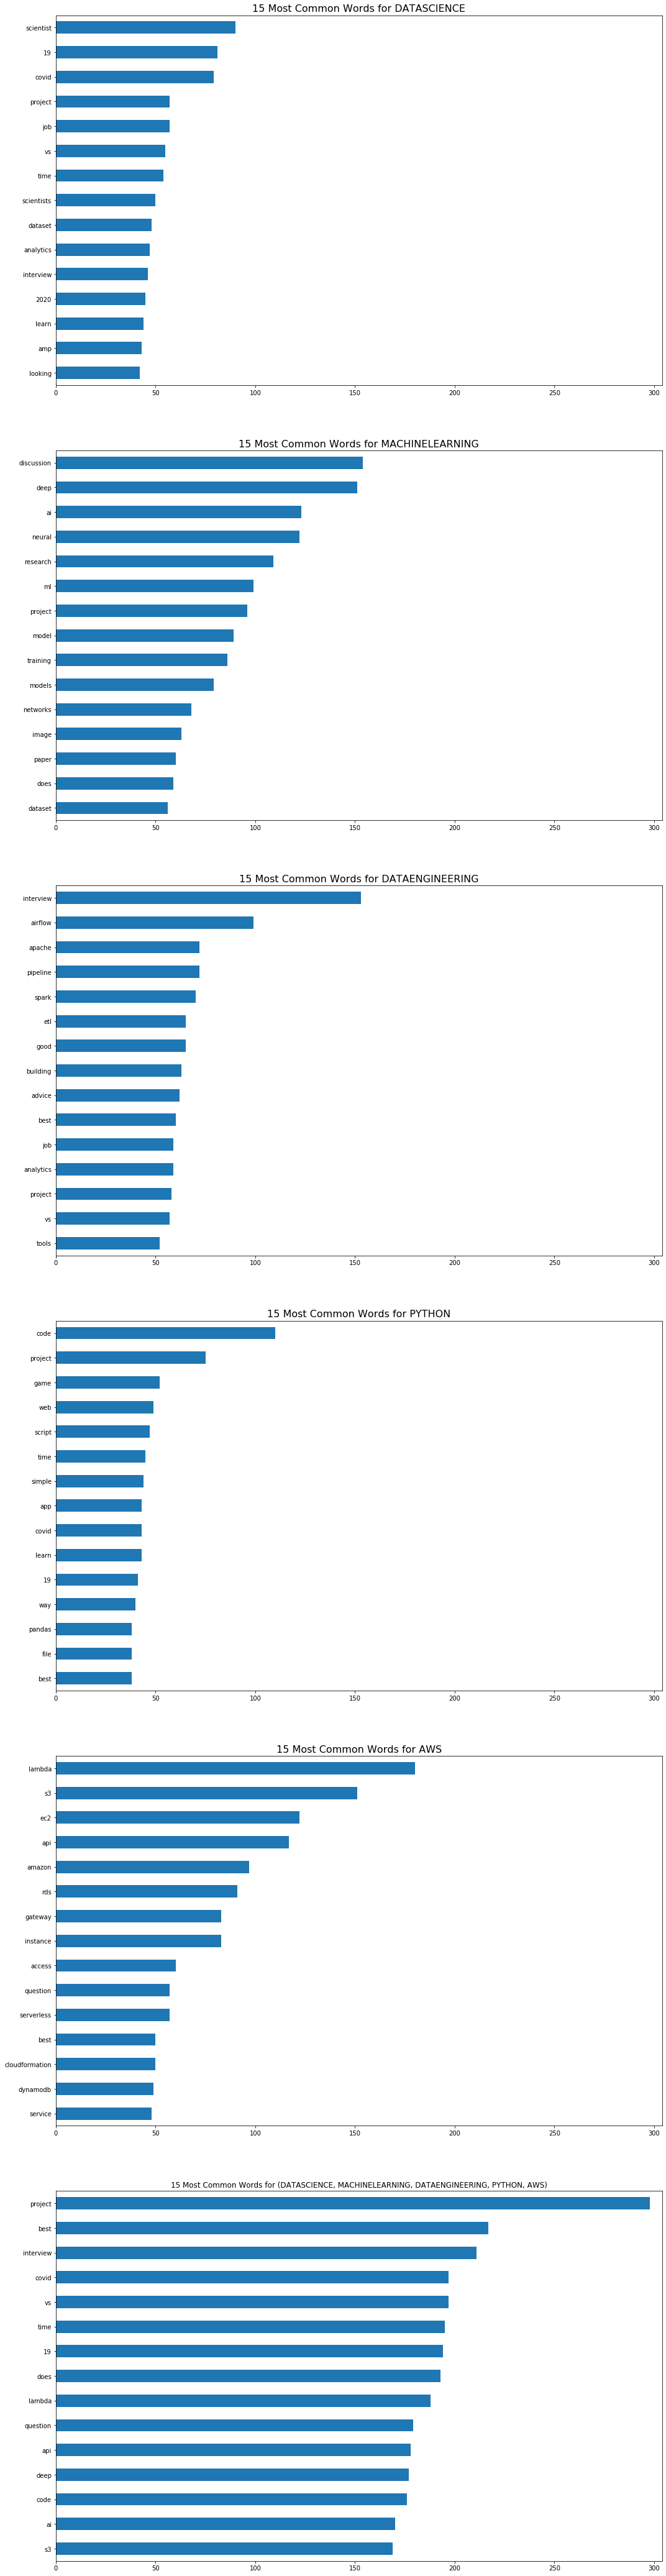

In [50]:
plot_most_common(df, features_df, num_features=15, include_combined=True, standardize=True)

In [51]:
most_common = features_df.sum().sort_values(ascending=False).head(20)[::-1]
groups = features_df.groupby(df['subreddit']).sum()[most_common.index].T.head(20)

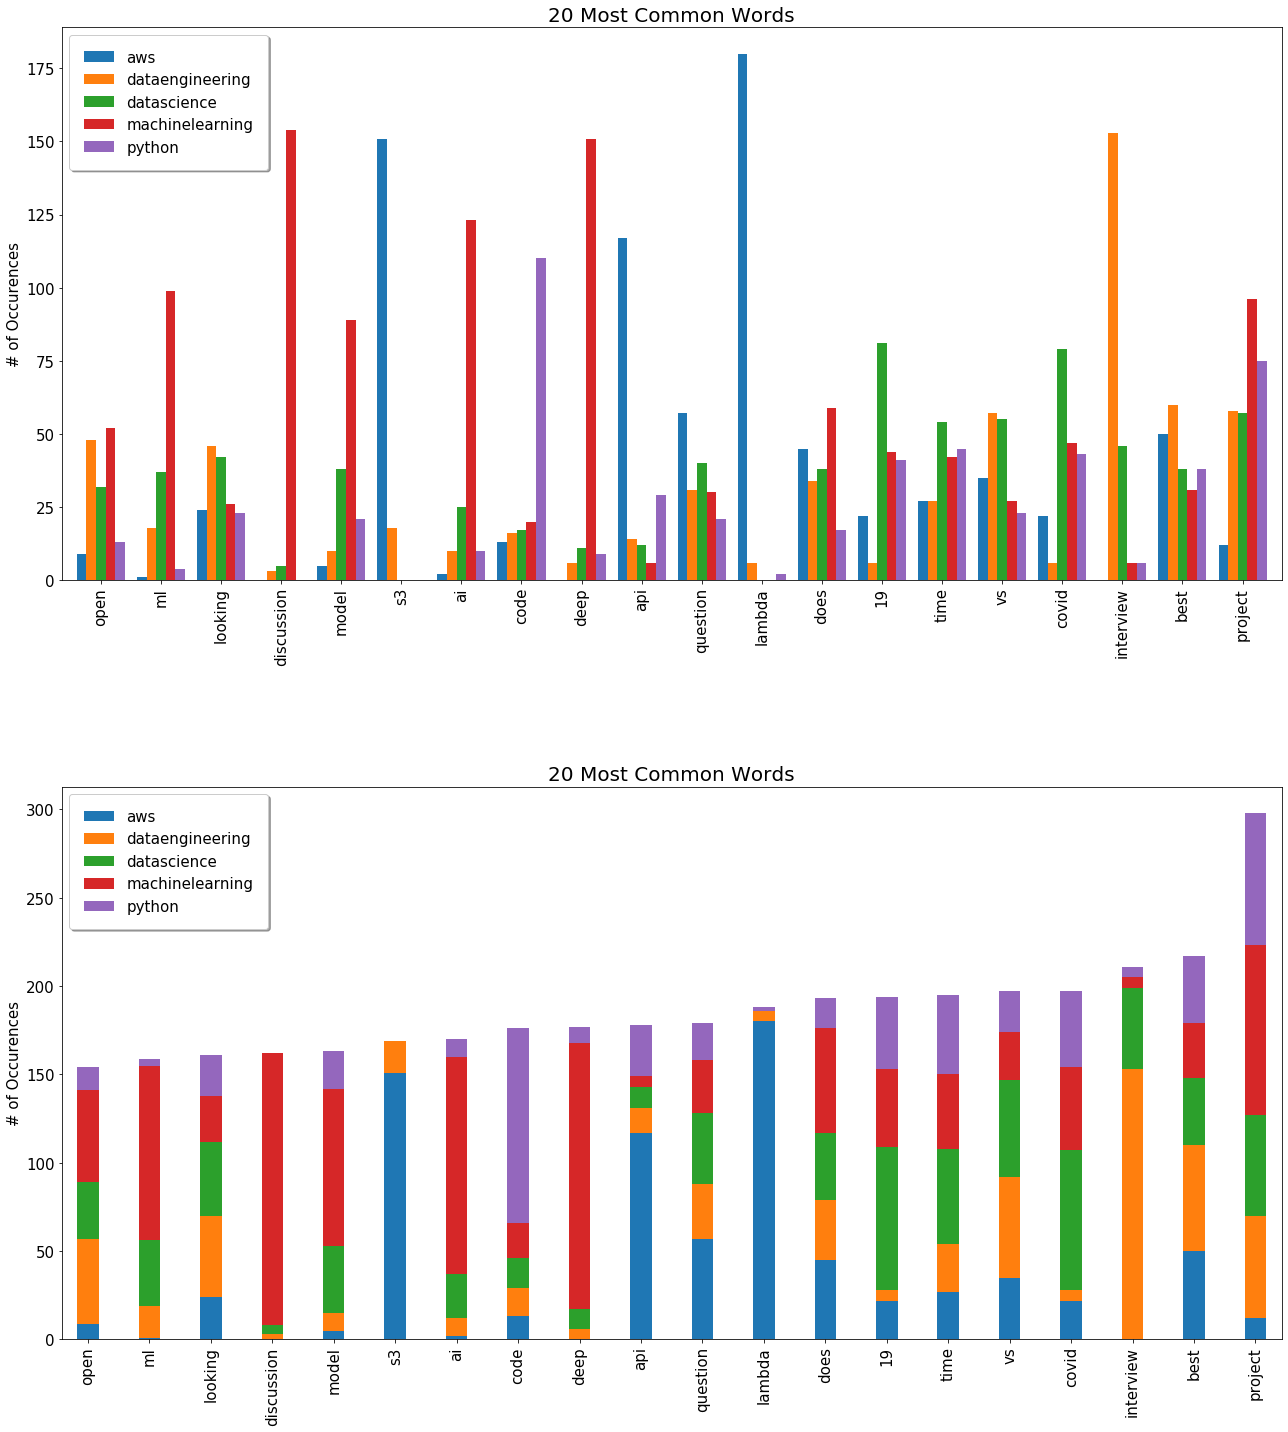

In [52]:
fig, ax = plt.subplots(nrows=2, figsize=(18,20))

groups.plot.bar(ax=ax[0], width=.8, fontsize=15)
ax[0].set_title('20 Most Common Words', fontsize=20)
ax[0].set_ylabel('# of Occurences', fontsize=15)
ax[0].legend(fontsize=15, fancybox=True, framealpha=1, shadow=True, borderpad=1)

groups.plot(kind='bar', ax=ax[1], width=.35, fontsize=15, stacked=True)
ax[1].set_title('20 Most Common Words', fontsize=20)
ax[1].set_ylabel('# of Occurences', fontsize=15)
ax[1].legend(fontsize=15, fancybox=True, framealpha=1, shadow=True, borderpad=1)


plt.tight_layout(h_pad=10);

In [53]:
# NOTE ### this does not use the X value inputted when using split...


def make_cloud(X, height=300, width=800, max_words=100, split=None, labels=None, stopwords=None, colormap='viridis', background_color='black'):
    '''
    Inputs:
    X: text input
    height: height of each wordcloud
    width: width of each wordcloud
    max_words: max words for each wordcloud
    split: if True, wordcloud for each subreddit
    labels: must provide list of labels if split=True, to generate a wordcloud for each label
    stopwords: usually these are the same stopwords used by the tranformer (CountVectorizer or Tfidf)
    colormap: any choice from matplotlib gallery.  Find them with plt.cm.datad
        'random': picks a random colormap for each cloud.
    '''

    colormaps = [m for m in plt.cm.datad if not m.endswith("_r")]
    wc = wordcloud.WordCloud(max_words=max_words,
                             width=width,
                             height=height,
                             background_color=background_color,
                             colormap=np.random.choice(
                                 colormaps) if colormap == 'random' else colormap,
                             stopwords=stopwords)
    if split:
        for label in labels:
            cloud = wc.generate(
                df[df['subreddit'] == label]['title'].str.cat())
            plt.figure(figsize=(width/100, height*len(labels)/100), dpi=100)
            plt.title(label.upper(), fontdict={'fontsize': 15})
            plt.axis("off")
            plt.imshow(cloud.to_image(), interpolation='bilinear')

    else:
        cloud = wc.generate(X.str.cat())
        return cloud.to_image()

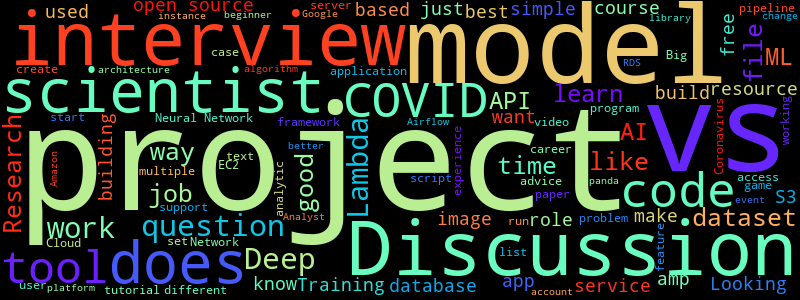

In [54]:
make_cloud(X, stopwords=custom_stop_words, colormap='rainbow')

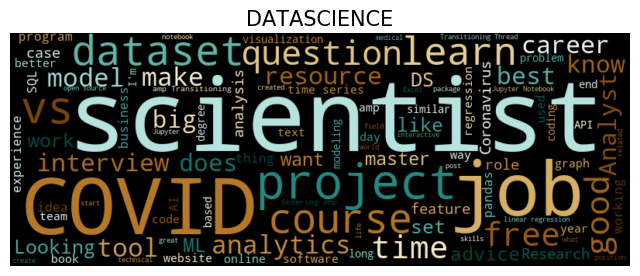

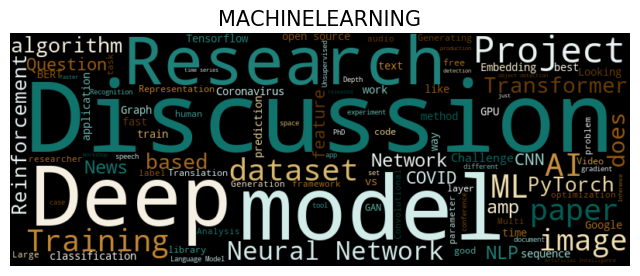

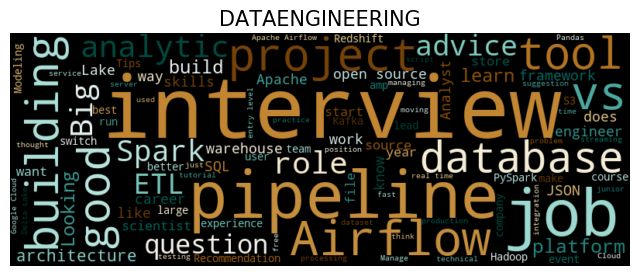

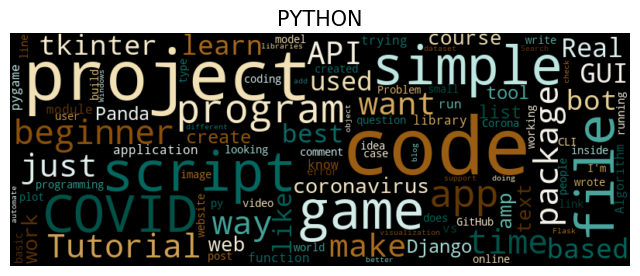

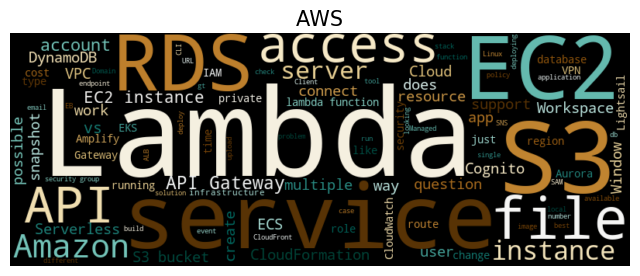

In [55]:
make_cloud(X, split=True, labels=subreddit_list, stopwords=custom_stop_words, colormap='random', background_color='black')

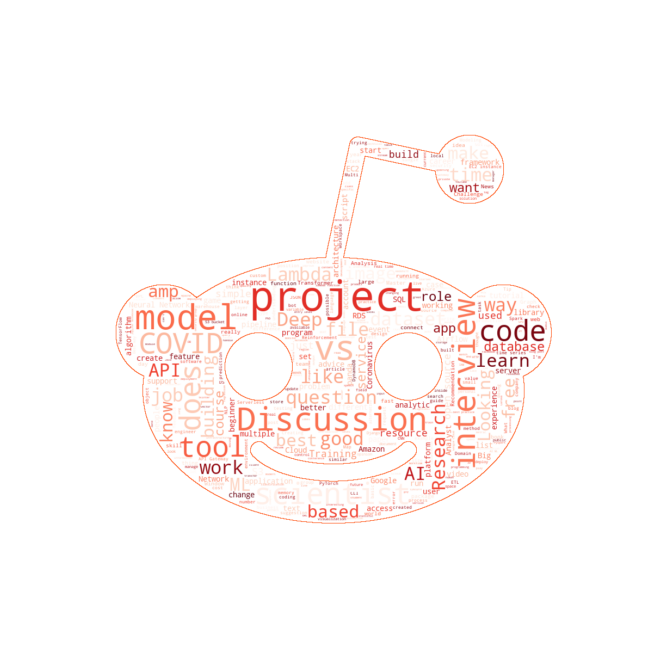

In [56]:
img = Image.open('../images/reddit03.png')
gray = np.array(img.convert('L'))
mask = np.where(gray < 200, 255, 0)

wc = wordcloud.WordCloud(background_color='white', 
                         max_words=500, 
                         mask=mask, 
                         colormap='Reds',
                         contour_color='orangered',
                         contour_width=1,
                         stopwords=custom_stop_words)
wc.generate(X.str.cat())
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis(False);

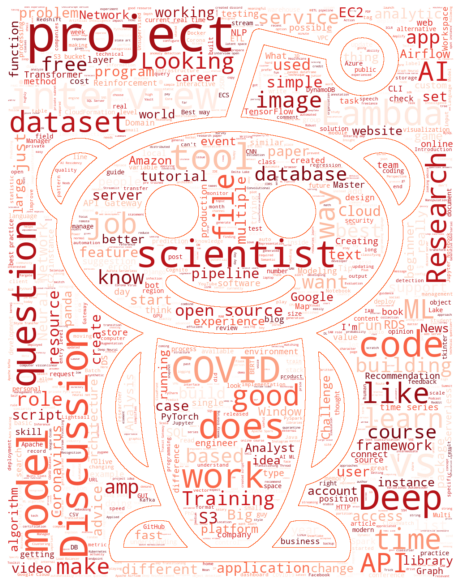

In [57]:
img2 = Image.open('../images/reddit02.jpg')
gray2 = np.array(img2.convert('L'))
mask2 = np.where(gray2 < 200, 255, 0)

wc2 = wordcloud.WordCloud(background_color='white', 
                         max_words=1000, 
                         mask=mask2, 
                         colormap='Reds',
                         contour_color='orangered',
                         contour_width=1,
                         stopwords=custom_stop_words)
wc2.generate(X.str.cat())
plt.figure(figsize=(8,12))
plt.imshow(wc2, interpolation='bilinear')
plt.axis(False)

plt.show()

<Figure size 504x504 with 0 Axes>

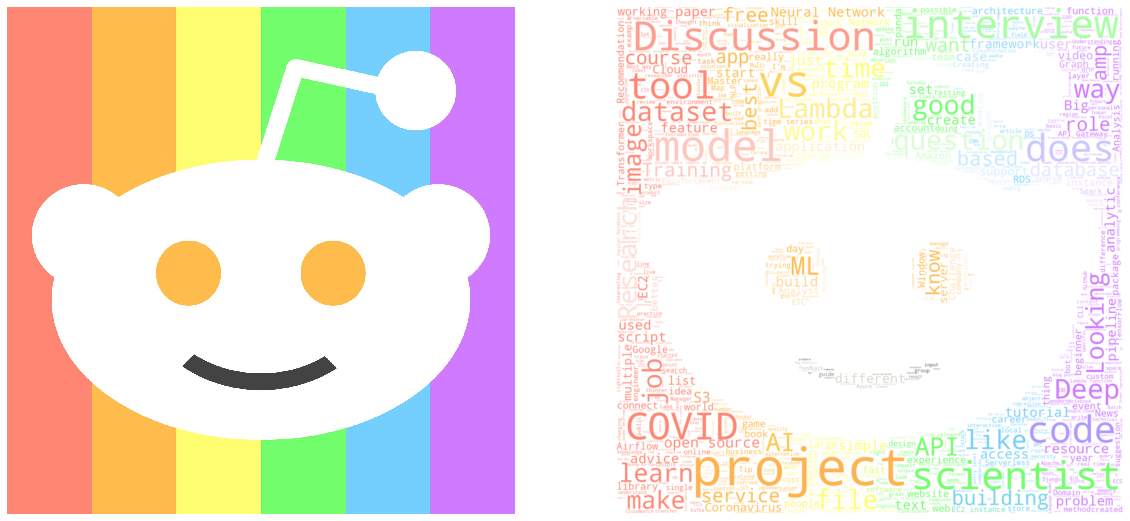

In [58]:
mask = np.array(Image.open("../images/reddit06.jpg"))
colorcloud = wordcloud.WordCloud(stopwords=custom_stop_words,
                                 background_color="white",
                                 mode="RGBA",
                                 max_words=1000,
                                 mask=mask)
colorcloud.generate(X.str.cat())

image_colors = wordcloud.ImageColorGenerator(mask)
plt.figure(figsize=[7, 7])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1.imshow(mask)
ax1.axis(False)

ax2.imshow(colorcloud.recolor(color_func=image_colors),
           interpolation="bilinear")
ax2.axis(False)

plt.show();